<a href="https://colab.research.google.com/github/casca/covid19-notebook/blob/master/charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DATA_SOURCE = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
dataset = pd.read_json(DATA_SOURCE)
# print(dataset.columns)

# format and sort by date
dataset['data'] = dataset['data'].transform(lambda s: s[:10])
dataset.sort_values(by=['data'], inplace=True)
dataset['data'] = pd.to_datetime(dataset['data'])
footer = f'Source https://github.com/pcm-dpc/COVID-19 - Last Updated {dataset["data"].tolist()[-1].strftime("%Y-%m-%d")}'
dataset['data'] = dataset['data'].dt.strftime('%d %b')

measures = {
            'deceduti': 'Deaths',
            'terapia_intensiva': 'Intensive Care',
            'dimessi_guariti': 'Recovered',
            'totale_positivi': 'Active Cases'
           }

sub_measures = {
                'delta': { 'color': 'plum', 'label': 'First Derivative', 'is_percentage': False },
                'delta_2': { 'color': 'sandybrown', 'label': 'Second Derivative', 'is_percentage': False },
                'delta_3': { 'color': 'yellowgreen', 'label': 'Third Derivative', 'is_percentage': False }
               }

for measure in measures:
    dataset[f'{measure}_delta'] = dataset[measure].diff()
    dataset[f'{measure}_delta_2'] = dataset[f'{measure}_delta'].diff()
    dataset[f'{measure}_delta_3'] = dataset[f'{measure}_delta_2'].diff()

dataset.drop(columns=['casi_testati', 'note', 'casi_da_sospetto_diagnostico', 'casi_da_screening'], inplace=True)
dataset.dropna(inplace=True)
dataset.tail(5)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,deceduti_delta,deceduti_delta_2,deceduti_delta_3,terapia_intensiva_delta,terapia_intensiva_delta_2,terapia_intensiva_delta_3,dimessi_guariti_delta,dimessi_guariti_delta_2,dimessi_guariti_delta_3,totale_positivi_delta,totale_positivi_delta_2,totale_positivi_delta_3
124,27 Jun,ITA,1260,97,1357,15479,16836,-802,175,188584,34716,240136,5277273,8.0,-22.0,-18.0,-8.0,-10.0,-16.0,969.0,79.0,-197.0,-802.0,-137.0,176.0
125,28 Jun,ITA,1160,98,1258,15423,16681,-155,174,188891,34738,240310,5314619,22.0,14.0,36.0,1.0,9.0,19.0,307.0,-662.0,-741.0,-155.0,647.0,784.0
126,29 Jun,ITA,1120,96,1216,15280,16496,-185,126,189196,34744,240436,5341837,6.0,-16.0,-30.0,-2.0,-3.0,-12.0,305.0,-2.0,660.0,-185.0,-30.0,-677.0
127,30 Jun,ITA,1090,93,1183,14380,15563,-933,142,190248,34767,240578,5390110,23.0,17.0,33.0,-3.0,-1.0,2.0,1052.0,747.0,749.0,-933.0,-748.0,-718.0
128,01 Jul,ITA,1025,87,1112,14143,15255,-308,187,190717,34788,240760,5445476,21.0,-2.0,-19.0,-6.0,-3.0,-2.0,469.0,-583.0,-1330.0,-308.0,625.0,1373.0


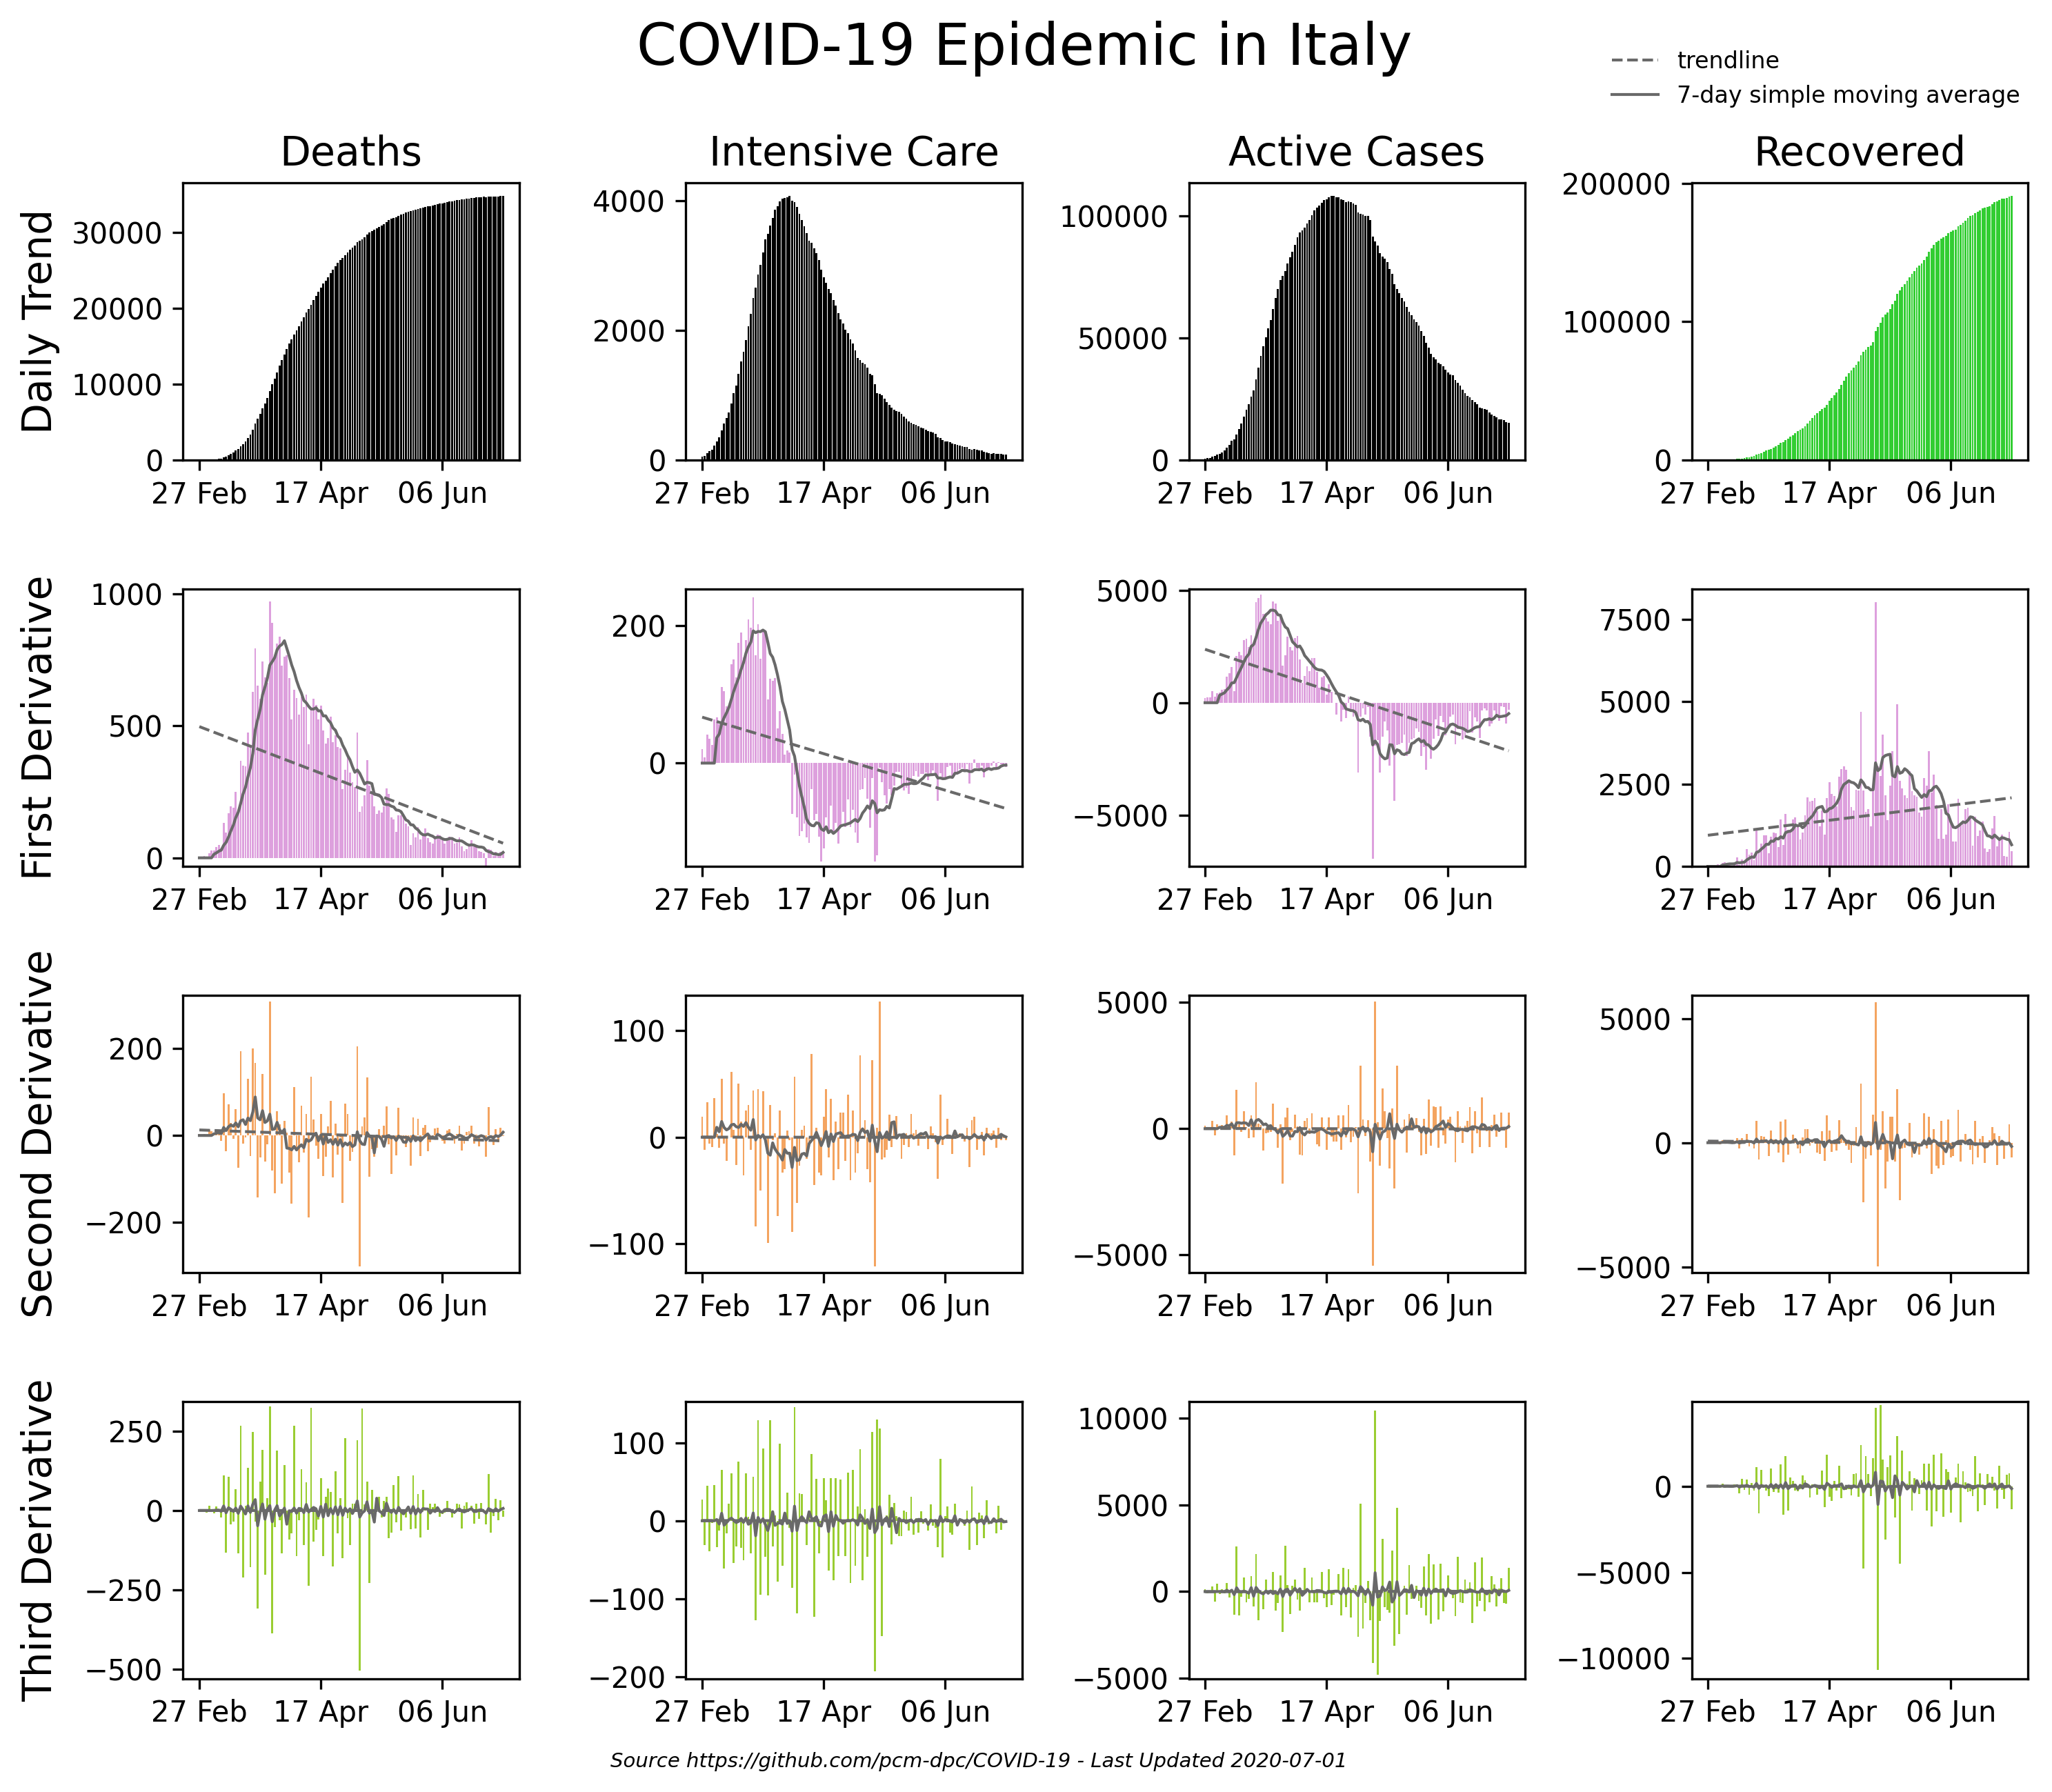

In [4]:
from matplotlib.lines import Line2D


moving_avg_days = 7

legend_lines = [Line2D([0], [0], color='dimgray', lw=1, ls='--'),
                Line2D([0], [0], color='dimgray', lw=1, ls='-')]
legend_labels = ('trendline', f'{moving_avg_days}-day simple moving average')


def plot(ax, measure, display_y_labels=False, main_color='black'):
    x = dataset['data']
    y = dataset[measure]

    ax[0].bar(x, y, color=main_color)
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax[0].set_title(measures[measure], fontsize=14)
    
    if display_y_labels:
        ax[0].set_ylabel('Daily Trend', fontsize=14)

    for i, sub_measure in enumerate(sub_measures):
        color = sub_measures[sub_measure]['color']
        label = sub_measures[sub_measure]['label']

        if display_y_labels:
            ax[i+1].set_ylabel(label, fontsize=14)

        y_sub = dataset[f'{measure}_{sub_measure}']
        ax[i+1].bar(x, y_sub, color=color, lw=1)

        # trendline
        z = np.polyfit(range(len(x)), y_sub, 1)
        p = np.poly1d(z)
        ax[i+1].plot(range(len(x)), p(range(len(x))), color='dimgray', lw=legend_lines[0].get_linewidth(), ls=legend_lines[0].get_linestyle())
        
        # n-day simple moving average
        rolling = y_sub.rolling(window=moving_avg_days).mean().fillna(value=0)
        ax[i+1].plot(range(len(x)), rolling, color='dimgray', lw=legend_lines[1].get_linewidth(), ls=legend_lines[1].get_linestyle())

        # limit number of x ticks
        ax[i+1].xaxis.set_major_locator(plt.MaxNLocator(3))

        # set range for y axes
        ax[i+1].set_ylim((min(0, y_sub.min()*1.05), y_sub.max()*1.05))


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8), dpi=300)

plot(axes[:, 0], 'deceduti', True)
plot(axes[:, 1], 'terapia_intensiva')
plot(axes[:, 2], 'totale_positivi')
plot(axes[:, 3], 'dimessi_guariti', False, 'limegreen')

plt.tight_layout()

# legend, title and footer
fig.legend(legend_lines, legend_labels, loc=(0.781, 0.935), fontsize=8, frameon=False)
fig.suptitle('COVID-19 Epidemic in Italy', y=1.05, fontsize=20)
fig.text(0.3, -0.005, footer, fontsize=7, style='italic')
fig.align_ylabels()

plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


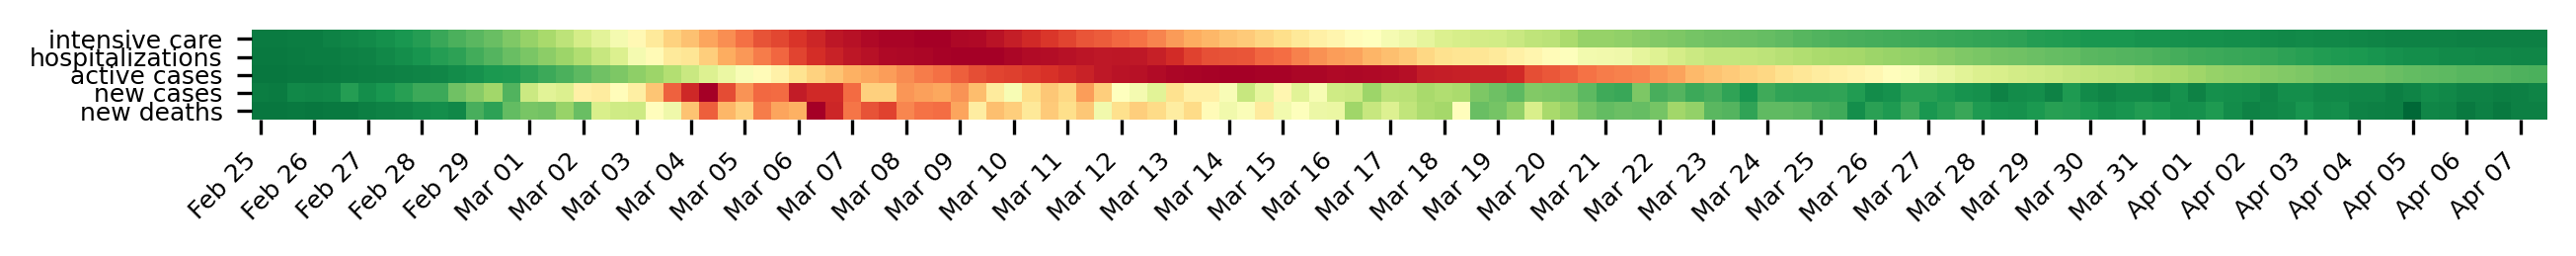

In [5]:
import seaborn as sns

dataset = pd.read_json(DATA_SOURCE, convert_dates=['data'])
dataset.drop(columns=['stato', 'ricoverati_con_sintomi', 'isolamento_domiciliare', 'totale_casi', 'casi_testati',
                      'variazione_totale_positivi' ,'dimessi_guariti', 'tamponi', 'casi_da_sospetto_diagnostico',
                      'casi_da_screening', 'note'], inplace=True)
dataset.columns = ['date', 'intensive care', 'hospitalizations',
                   'active cases', 'new cases', 'new deaths']
dataset['new deaths'] = dataset['new deaths'].diff()
dataset.dropna(inplace=True)
dataset.set_index('date', inplace=True)
dataset = dataset / dataset.max()

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

g = sns.heatmap(dataset.transpose(), square=True, cbar=False, cmap='RdYlGn_r')
g.set_xticklabels(dataset.index.strftime('%b %d'), rotation=45, horizontalalignment='right', fontsize=6)
g.set_yticklabels(map(lambda s: s.replace('_', ' '), list(dataset.columns)))
g.tick_params(axis="y", labelsize=6)

ax.set_xlabel('')
plt.show()

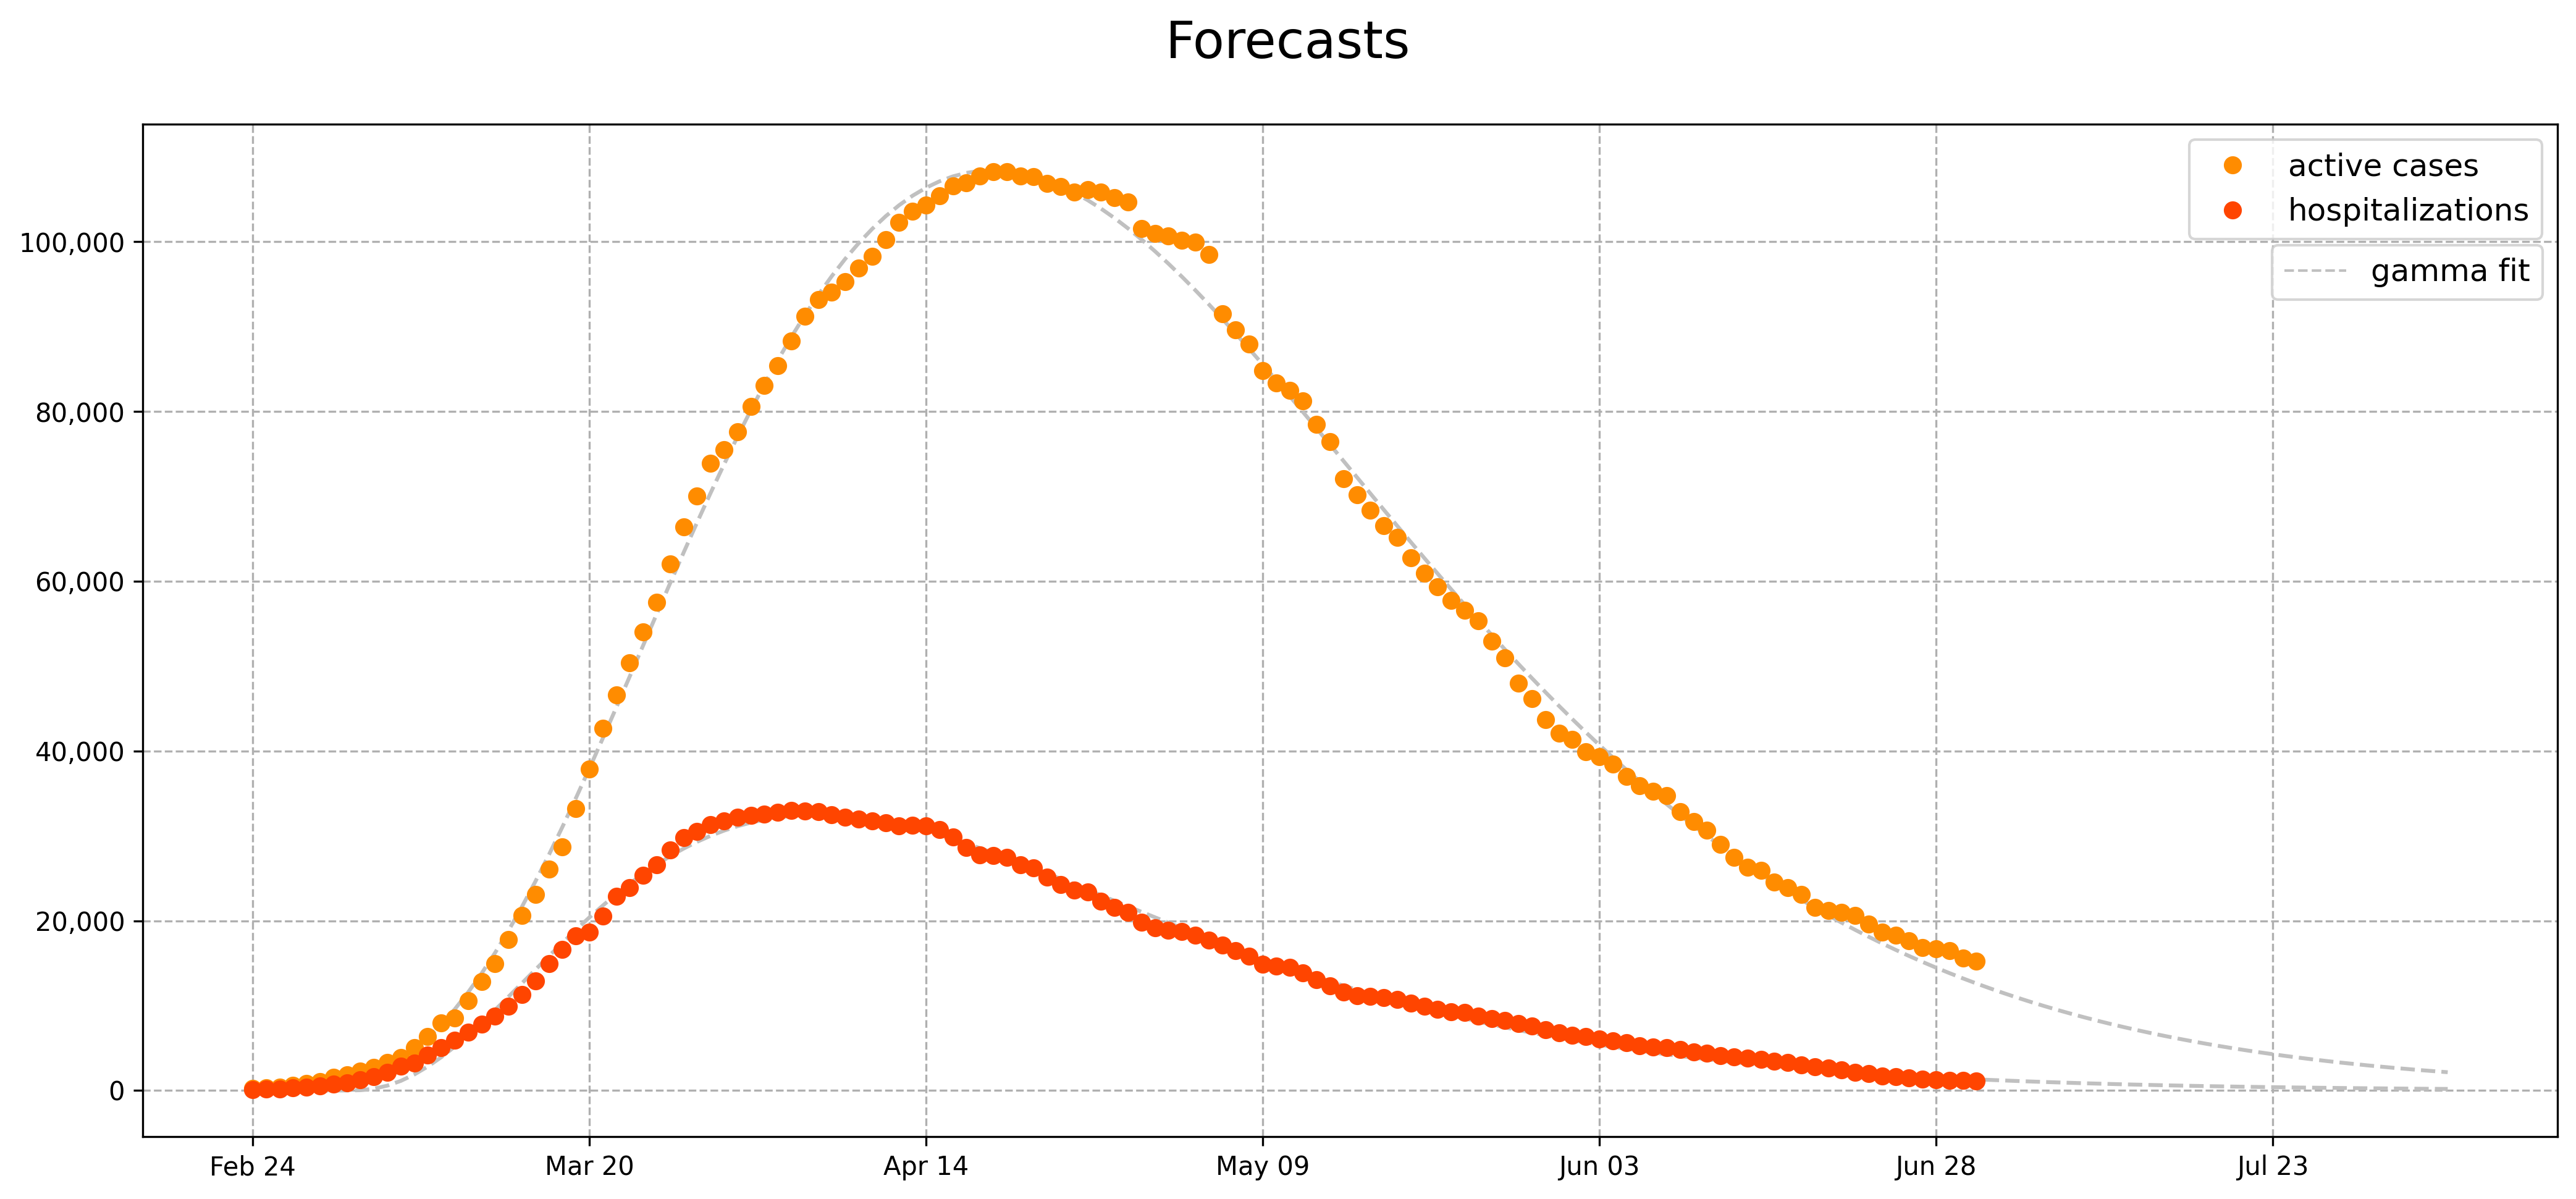

In [6]:
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit
from scipy.stats import logistic, gamma, lognorm
from datetime import datetime
from datetime import timedelta


FORECAST_WEEKS = 5
SECONDARY_COLOR = 'silver'


def logistic_amplified(x, loc, scale, c):
    return c * logistic.pdf(x, loc, scale)


def gamma_amplified(x, a, loc, scale, c):
    return c * gamma.pdf(x, a, loc, scale)


def lognorm_amplified(x, s, loc, scale, c):
    return c * lognorm.pdf(x, s, loc, scale)


def to_date_labels(arr):
    return list(map(lambda d: d.date().strftime('%b %d'), arr))


def fit_and_plot(axes, column, label, color):
    # extract data
    series = dataset[column]

    x_base = range(len(dates))

    # gamma fit
    popt, _ = curve_fit(gamma_amplified, x_base, series, p0=[2, 27, 1, 250000])
    axes.plot(extended_dates, gamma_amplified(x_extended, *popt), '--', color=SECONDARY_COLOR)
    
    # plot data points
    axes.plot(dates,series,'o', label=label, color=color)


dataset = pd.read_json(DATA_SOURCE)

dates = list(pd.to_datetime(dataset['data']))
extended_dates = dates + [dates[-1] + timedelta(days=1+i) for i in range(FORECAST_WEEKS * 7)]
today = dates[-1]

dates = to_date_labels(dates)
extended_dates = to_date_labels(extended_dates)
x_extended = range(len(dates) + FORECAST_WEEKS * 7)

fig, axes = plt.subplots(figsize=(14,6), dpi=300)

fit_and_plot(axes, 'totale_positivi', 'active cases', 'darkorange')
fit_and_plot(axes, 'totale_ospedalizzati', 'hospitalizations', 'orangered')

# makeup
axes.legend(loc='best', fontsize=12)
axes.xaxis.set_major_locator(plt.MaxNLocator(8))
axes.grid(b=True, which='major', linestyle='--')
axes.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

fig.suptitle('Forecasts', y=1.07, fontsize=20)
legend_lines = [Line2D([0], [0], color=SECONDARY_COLOR, lw=1, ls='--')]
fig.legend(legend_lines, ['gamma fit'], fontsize=12, loc=(0.882, 0.75))
plt.tight_layout()

plt.show()

# 13-Apr-2020
# totale_positivi gamma 6.585804076185623 -2.7165780647597866 9.566070442648238 5840522.330988012
# totale_positivi log-normal 0.38719721049168704 -12.062018373460333 74.09918439380117 6815695.309800047
# totale_positivi logistic 44.98100608664922 8.987932607311008 3583871.4662856665
# totale_ospedalizzati gamma 9.921771866534678 -10.221758579313324 5.707577294510004 1440671.449081458
# totale_ospedalizzati log-normal 0.2657523724999857 -24.569709752444112 70.02815769271169 1501503.9257751794
# totale_ospedalizzati logistic 40.16496142352202 8.757121487661799 1221864.76720857